# Dataset tests of Autometacal Proof-of-Concept

This is a modified version of the Fourier proof-of-concept notebook that repeats the same steps, side by side with the original nb and an example from the dataset. 

The database example has:
- example['gal_image']  # the observation of the galaxy, convolved with the psf
- example['psf_image']  # the image of the psf
- example['gal_kimage'] # k space image of observation
- example['psf_kimage'] # k space image of psf
- example['label']      # g1, g2 of galaxy

Noise in the database is gaussian with SNR $200\pm20$

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import galsim
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import sys

In [3]:
sys.path.append("..")
import autometacal

In [4]:
autometacal

<module 'autometacal' from '../autometacal/__init__.py'>

In [5]:
import tensorflow_datasets as tfds

## Dataset

In [6]:
data = tfds.load('gal_gen/small_stamp_100',as_supervised=False,with_info=False)
data = data['train'].take(100)
datait = data.as_numpy_iterator()
datalist=[next(datait) for i in range(100)]
example = datalist[0]

## Create Galaxy Model

Original:

In [7]:
gal_flux = 1.e5    # counts
gal_r0 = 2.7       # arcsec
g1 = 0.1           #
g2 = 0.2           #
pixel_scale = 0.2  # arcsec / pixel
img_size = 50

psf_beta = 5       #
psf_re = 1.0       # arcsec


# Define the galaxy profile.
gal = galsim.Exponential(flux=gal_flux, scale_radius=gal_r0)
# To make sure that GalSim is not cheating, i.e. using the analytic formula of the light profile
# when computing the affine transformation, it might be a good idea to instantiate the image as
# an interpolated image.
# We also make sure GalSim is using the same kind of interpolation as us (bilinear for TF)
gal = galsim.InterpolatedImage(gal.drawImage(nx=img_size,ny=img_size, scale=pixel_scale),
                               x_interpolant='linear')

# Shear the galaxy by some value.
# There are quite a few ways you can use to specify a shape.
# q, beta      Axis ratio and position angle: q = b/a, 0 < q < 1
# e, beta      Ellipticity and position angle: |e| = (1-q^2)/(1+q^2)
# g, beta      ("Reduced") Shear and position angle: |g| = (1-q)/(1+q)
# eta, beta    Conformal shear and position angle: eta = ln(1/q)
# e1,e2        Ellipticity components: e1 = e cos(2 beta), e2 = e sin(2 beta)
# g1,g2        ("Reduced") shear components: g1 = g cos(2 beta), g2 = g sin(2 beta)
# eta1,eta2    Conformal shear components: eta1 = eta cos(2 beta), eta2 = eta sin(2 beta)
gal0 = gal.shear(g1=g1, g2=g2)

psf = galsim.Moffat(beta=psf_beta, flux=1., half_light_radius=psf_re)

gal = galsim.Convolve([gal0, psf])

In [8]:
image_original = gal0.original.drawImage(nx=img_size,ny=img_size, scale=pixel_scale, method='no_pixel').array
image_shear = gal.drawImage(nx=img_size,ny=img_size,scale=pixel_scale, method='no_pixel', use_true_center=False).array

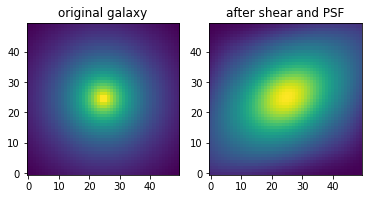

In [9]:
subplot(121)
imshow(image_original, origin='lower')
title('original galaxy')
subplot(122)
title('after shear and PSF')
imshow(image_shear, origin='lower')

Dataset:

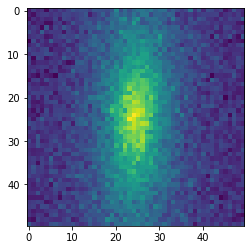

In [10]:
imshow(example['gal_image'])

## Create simple shear measurements

In [11]:
import tensorflow as tf
# let's try to do shape measurement using weigthed moments
nx = img_size
ny = img_size
XX=np.zeros((nx,ny))
XY=np.zeros((nx,ny))
YY=np.zeros((nx,ny))
w = np.zeros((nx,ny))
sigma=40

for i in range(0,nx):
    x=0.5+i-(nx)/2.0
    for j in range(0,ny):
        y=0.5+j-(ny)/2.0
        XX[i,j]=x*x
        XY[i,j]=x*y
        YY[i,j]=y*y
        w[i,j]=np.exp(-((x) ** 2 + (y) ** 2) /
                               (2 * sigma ** 2))

def get_ellipticity(img):
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    norm = tf.reduce_sum(w*img)
    Q11 = tf.reduce_sum(w*img*YY)/norm
    Q12 = tf.reduce_sum(w*img*XY)/norm
    Q21 = Q12
    Q22 = tf.reduce_sum(w*img*XX)/norm
    
    q1 = Q11 - Q22
    q2 = 2*Q12
    
    T= Q11 + Q22  + 2*tf.sqrt(Q11*Q22 - Q12**2)
    return q1/T, q2/T

In [12]:
get_ellipticity(image_shear+10*randn(img_size,img_size))

(<tf.Tensor: shape=(), dtype=float32, numpy=0.04532024>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.11051505>)

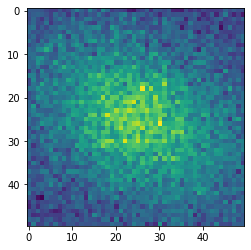

In [13]:
imshow(w*(image_shear+10*randn(img_size,img_size)))

Dataset:

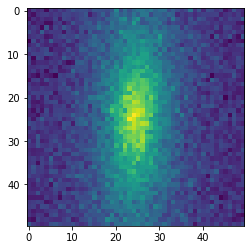

In [14]:
imshow(example['gal_image'])

In [15]:
print(get_ellipticity(example['gal_image']))
print("True:", example['label'])

(<tf.Tensor: shape=(), dtype=float32, numpy=-0.27177805>, <tf.Tensor: shape=(), dtype=float32, numpy=-0.029536014>)
True: [-0.52710474 -0.0362318 ]


## Create kspace images

In [16]:
noise = galsim.GaussianNoise().withVariance(10)
obs_imag = gal.drawImage(nx=img_size,ny=img_size, scale=pixel_scale, method='no_pixel')
noise.applyTo(obs_imag)

# Make noise image
noise_imag = galsim.Image(img_size,img_size, scale=pixel_scale)
noise.applyTo(noise_imag)

# Building observed image object
obs = galsim.InterpolatedImage(obs_imag)
nos = galsim.InterpolatedImage(noise_imag)

In [17]:
# We draw the PSF image in Kspace at the correct resolution
N = img_size
im_scale = pixel_scale
interp_factor=2
padding_factor=1
Nk = N*interp_factor*padding_factor
from galsim.bounds import _BoundsI

bounds = _BoundsI(-Nk//2, Nk//2-1, -Nk//2, Nk//2-1)

impsf = psf.drawKImage(bounds=bounds,
                       scale=2.*np.pi/(N*padding_factor* im_scale),
                       recenter=False)

ipsf = galsim.Deconvolve(psf)

imipsf = ipsf.drawKImage(bounds=bounds,
                       scale=2.*np.pi/(N*padding_factor* im_scale),
                       recenter=False)

imgal = obs.drawKImage(bounds=bounds,
                       scale=2.*np.pi/(N*padding_factor* im_scale),
                       recenter=False)

imnos = nos.drawKImage(bounds=bounds,
                       scale=2.*np.pi/(N*padding_factor* im_scale),
                       recenter=False)

In [18]:
imipsf.array.shape

(100, 100)

In [19]:
tfimpsf = tf.convert_to_tensor(impsf.array, dtype=tf.complex64)
tfimipsf = tf.convert_to_tensor(imipsf.array, dtype=tf.complex64)
tfimgal = tf.convert_to_tensor(imgal.array, dtype=tf.complex64)
tfimnos = tf.convert_to_tensor(imnos.array, dtype=tf.complex64)

In [20]:
tfimgal = tf.expand_dims(tfimgal ,0)
tfimnos = tf.expand_dims(tfimnos ,0)
tfimpsf = tf.expand_dims(tfimpsf ,0)
tfimipsf = tf.expand_dims(tfimipsf ,0)
tfimpsf = tf.signal.fftshift(tfimpsf,axes=2)[:,:,:(img_size*interp_factor*padding_factor)//2+1]

Dataset:

In [21]:
psf_kimage = autometacal.datasets.gal_gen.recomplexify(example['psf_kimage'])
gal_kimage = autometacal.datasets.gal_gen.recomplexify(example['gal_kimage'])

In [22]:
dataset_psf_gs = galsim.InterpolatedImage(galsim.Image(example['psf_image'],scale=0.2)) #I think the error is here

psf_inverse = galsim.Deconvolve(dataset_psf_gs)

invpsf = psf_inverse.drawKImage(bounds=bounds,
                       scale=2.*np.pi/(N*padding_factor*im_scale),
                       recenter=False)

In [23]:
tfimpsf_dataset = tf.convert_to_tensor(psf_kimage, dtype=tf.complex64)   #psf k image
tfimipsf_dataset = tf.convert_to_tensor(invpsf.array, dtype=tf.complex64)#psf deconv 
tfimgal_dataset = tf.convert_to_tensor(gal_kimage, dtype=tf.complex64)# gal k image 
#tfimnos_dataset = tf.convert_to_tensor(imnos.array, dtype=tf.complex64)# noise image

In [24]:
tfimgal_dataset = tf.expand_dims(tfimgal_dataset ,0) #gal k image
#tfimnos_dataset = tf.expand_dims(tfimnos_dataset ,0) #noise k image
tfimpsf_dataset = tf.expand_dims(tfimpsf_dataset ,0) # psf k image
tfimipsf_dataset = tf.expand_dims(tfimipsf_dataset ,0) #psf deconv
tfimpsf_dataset = tf.signal.fftshift(tfimpsf_dataset,axes=2)[:,:,:(img_size*interp_factor*padding_factor)//2+1]

## Show Conv/Deconv

In [25]:
import galflow as gf

ModuleNotFoundError: No module named 'galflow'

In [ ]:
# Deconvolve image
temp = tfimgal * tfimipsf
temp = tf.signal.fftshift(temp,axes=2)[:,:,:(img_size*interp_factor*padding_factor)//2+1]
# Reconvolve image
tst2 = gf.kconvolve(temp, tfimpsf)[...,0]
tst2 = tf.expand_dims(tf.signal.fftshift(tst2),-1)
tst2 = tf.image.resize_with_crop_or_pad(tst2, img_size, img_size)

In [ ]:
figure(figsize=[15,5])
subplot(131)
title('input image')
imshow(image_shear)
subplot(132)
title('reconvolved image')
imshow(tst2[0]);
subplot(133)
title('residuals image')
imshow(((tst2[0,...,0] - obs_imag.array)));# colorbar();

Dataset:

In [ ]:
# Deconvolve image
temp_dataset = tfimgal_dataset * tfimipsf_dataset
temp_dataset = tf.signal.fftshift(temp_dataset,axes=2)[:,:,:(img_size*interp_factor*padding_factor)//2+1]
# Reconvolve image
tst2_dataset = gf.kconvolve(temp_dataset, tfimpsf_dataset)[...,0]
tst2_dataset = tf.expand_dims(tf.signal.fftshift(tst2_dataset),-1)
tst2_dataset = tf.image.resize_with_crop_or_pad(tst2_dataset, img_size, img_size)

In [ ]:
figure(figsize=[15,5])
subplot(131)
title('input image')
imshow(example['gal_image'])
subplot(132)
title('reconvolved image')
imshow(tst2_dataset[0]);
subplot(133)
title('residuals image')
imshow(((tst2_dataset[0,...,0] - example['gal_image'])));# colorbar();

## Metacal Test

In [ ]:
# Ok... so now can we make a poor man's metacal
def to_rfft(x):
    return tf.signal.fftshift(x,axes=2)[:,:,:(img_size*interp_factor*padding_factor)//2+1]

@tf.function
def metacal_shear(gal_img, nos_img, inv_psf_img, psf_img, g1, g2):
    g1 = tf.reshape(tf.convert_to_tensor(g1, dtype=tf.float32), [-1])
    g2 = tf.reshape(tf.convert_to_tensor(g2, dtype=tf.float32), [-1])
        
    # Step1: remove observed psf
    img = gal_img * inv_psf_img
    imgn = nos_img * inv_psf_img
    
    # Step2: add shear layer
    img = gf.shear(tf.expand_dims(img,-1), g1, g2)[...,0]
    imgn = gf.shear(tf.expand_dims(imgn,-1), -g1, -g2)[...,0]
    
    # Step3: apply psf again
    img = gf.kconvolve(to_rfft(img), (psf_img))[...,0]
    img = tf.expand_dims(tf.signal.fftshift(img),-1)
    img = tf.image.resize_with_crop_or_pad(img, img_size, img_size)
    
    imgn = gf.kconvolve(to_rfft(imgn), (psf_img))[...,0]
    imgn = tf.expand_dims(tf.signal.fftshift(imgn),-1)
    imgn = tf.image.resize_with_crop_or_pad(imgn, img_size, img_size)
    
    # Adding the inversed sheared noise
    img += imgn
    
    # Step4: compute ellipticity
    return img, tf.stack(get_ellipticity(img[0,:,:,0] ))

In [ ]:
i, res = metacal_shear(tfimgal, tfimnos, tfimipsf, tfimpsf, 0.05, 0.05)
print("measured shape", res.numpy())
figure(figsize=[10,5])
subplot(121)
title('input image')
imshow(obs_imag.array)
subplot(122)
title('metacal image')
imshow(i[0,:,:,0])

In [ ]:
res.numpy()

In [ ]:
# True ellipticity: [0.1, 0.2]
@tf.function
def get_metacal_response(tfimgal, tfimnos, tfimipsf, tfimpsf):
    g = tf.zeros(2)
    with tf.GradientTape() as tape:
        tape.watch(g)
        # Measure ellipticity under metacal
        _, e = metacal_shear(tfimgal, tfimnos, tfimipsf, tfimpsf, g[0], g[1])
    # Compute response matrix
    R = tape.jacobian(e, g)
    return e, R

In [ ]:
e,R = get_metacal_response(tfimgal, tfimnos, tfimipsf, tfimpsf)

In [ ]:
# Apply inverse response matrix :-D
calibrated_e = tf.linalg.inv(R) @ tf.reshape(e,[2,1])

In [ ]:
print("measured ellipticity  ", e.numpy())
print("calibrated ellipticity", calibrated_e.numpy().squeeze())
print("true g1,g2            ",np.array([g1,g2]))